# Phase curve integrals

In this notebook we validate our analytic expression for the phase curve solution vector, $\mathbb{r}^\top$.

In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import dblquad

Let's code up a function `poly_basis(y, x, n)` that returns the $n^\text{th}$ term of the polynomial basis vector evaluated at the point $(x, y)$:

In [31]:
def get_ijk(n):
    """Get the exponents of x, y, z i the nth term of the polynomial basis."""
    l = int(np.floor(np.sqrt(n)))
    m = n - l * l - l
    mu = l - m
    nu = l + m
    if mu % 2 == 0:
        i = mu // 2
        j = nu // 2
        k = 0
    else:
        i = (mu - 1) // 2
        j = (nu - 1) // 2
        k = 1
    return i, j, k


def poly_basis_term(y, x, n):
    """Return the n^th term of the polynomial basis evaluated at the point (x, y)."""
    z = np.sqrt(1 - x ** 2 - y ** 2)
    i, j, k = get_ijk(n)
    return x ** i * y ** j * z ** k

Here's the integral form of the expression for the solution vector $\mathbb{r}^\top$, evaluated numericaly by two-dimensional Gaussian quadrature:

In [98]:
def rT_numerical(b, deg):
    N = (deg + 1) ** 2
    rT = np.zeros(N)
    for n in range(N):
        rT[n], _ = dblquad(
            poly_basis_term,
            -1,
            1,
            lambda x: b * np.sqrt(1 - x ** 2),
            lambda x: np.sqrt(1 - x ** 2),
            args=(n,),
            epsabs=1e-12,
            epsrel=1e-12
        )
    return rT

And here's our analytic expression:

In [107]:
def k(b, j):
    bc = np.sqrt(1 - b ** 2)
    if j == 0:
        return 0.5 * (np.arccos(b) - b * bc)
    elif j == 1:
        return bc ** 3 / 3.0
    else:
        return (b ** (j - 1) * bc ** 3 + (j - 1) * k(b, j - 2)) / (j + 2.0)


def L(i, j):
    if i == j == 0:
        return np.pi
    elif i == 0 and j == 1:
        return 4.0 / 3.0
    elif i == 0:
        return (j - 1.0) / (j + 2.0) * L(0, j - 2)
    else:
        return (i - 1.0) / (i + j + 2.0) * L(i - 2, j)


def M(i, j):
    if i == j == 0:
        return 4.0 / 3.0
    elif i == 0 and j == 1:
        return 3.0 * np.pi / 8.0
    elif i == 0:
        return (j + 2.0) / (j + 3.0) * M(0, j - 2)
    else:
        return (i - 1.0) / (i + j + 3.0) * M(i - 2, j)


def rT(b, deg):
    N = (deg + 1) ** 2
    rT = np.zeros(N)
    for n in range(N):
        l = int(np.floor(np.sqrt(n)))
        m = n - l * l - l
        mu = l - m
        nu = l + m   
        if mu % 2 == 0:
            if (mu / 2) % 2 == 0:
                rT[n] = 0.5 * (1 - b ** (0.5 * (nu + 2))) * L(0.5 * mu, 0.5 * nu)
        else:
            if ((mu - 1) / 2) % 2 == 0:
                rT[n] = k(b, 0.5 * (nu - 1)) * M(0.5 * (mu - 1), 0.5 * (nu - 1))
    return rT

Let's code up a function to compare the two expressions...

In [108]:
def compare(b, deg):
    fig, ax = plt.subplots(2, sharex=True, figsize=(14, 6))
    f1 = rT(b, deg)
    f2 = rT_numerical(b, deg)
    ax[0].plot(f1, label="analytic")
    ax[0].plot(f2, "C1o", label="numerical")
    ax[0].legend()
    ax[0].set_ylabel("rT")
    ax[1].plot(np.maximum(2e-15, np.abs(f1 - f2)), "k-")
    ax[1].set_yscale("log")
    ax[1].set_ylim(1e-15, 1e0)
    ax[1].set_ylabel("diff")
    ax[1].set_xlabel("n");

... and show that they're equivalent (to within the numerical error of `dblquad`). We'll do it up to degree `4` as an example, and look at a few different values of `b`.

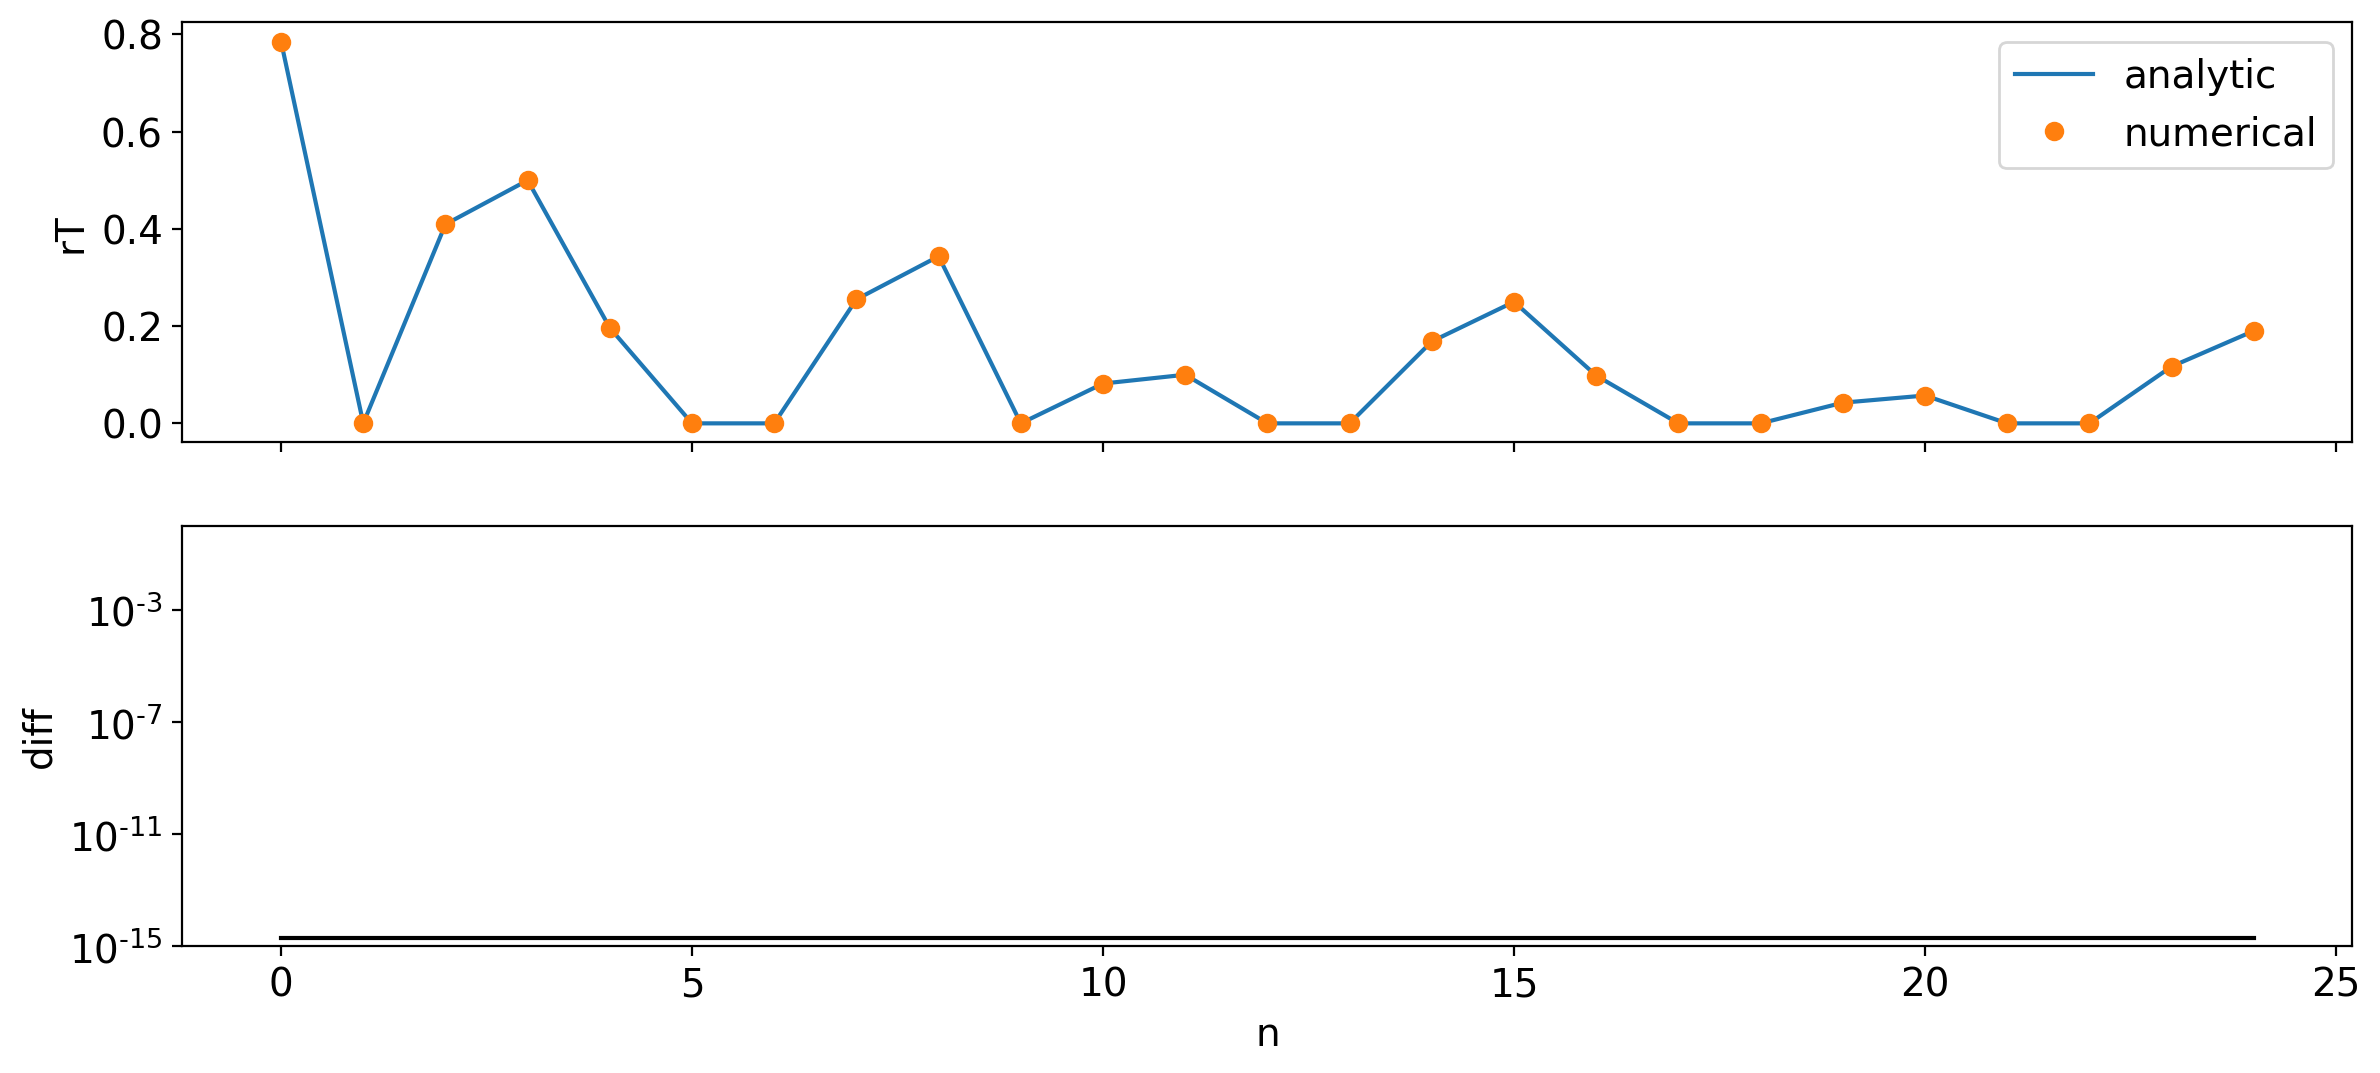

In [109]:
compare(0.5, 4)

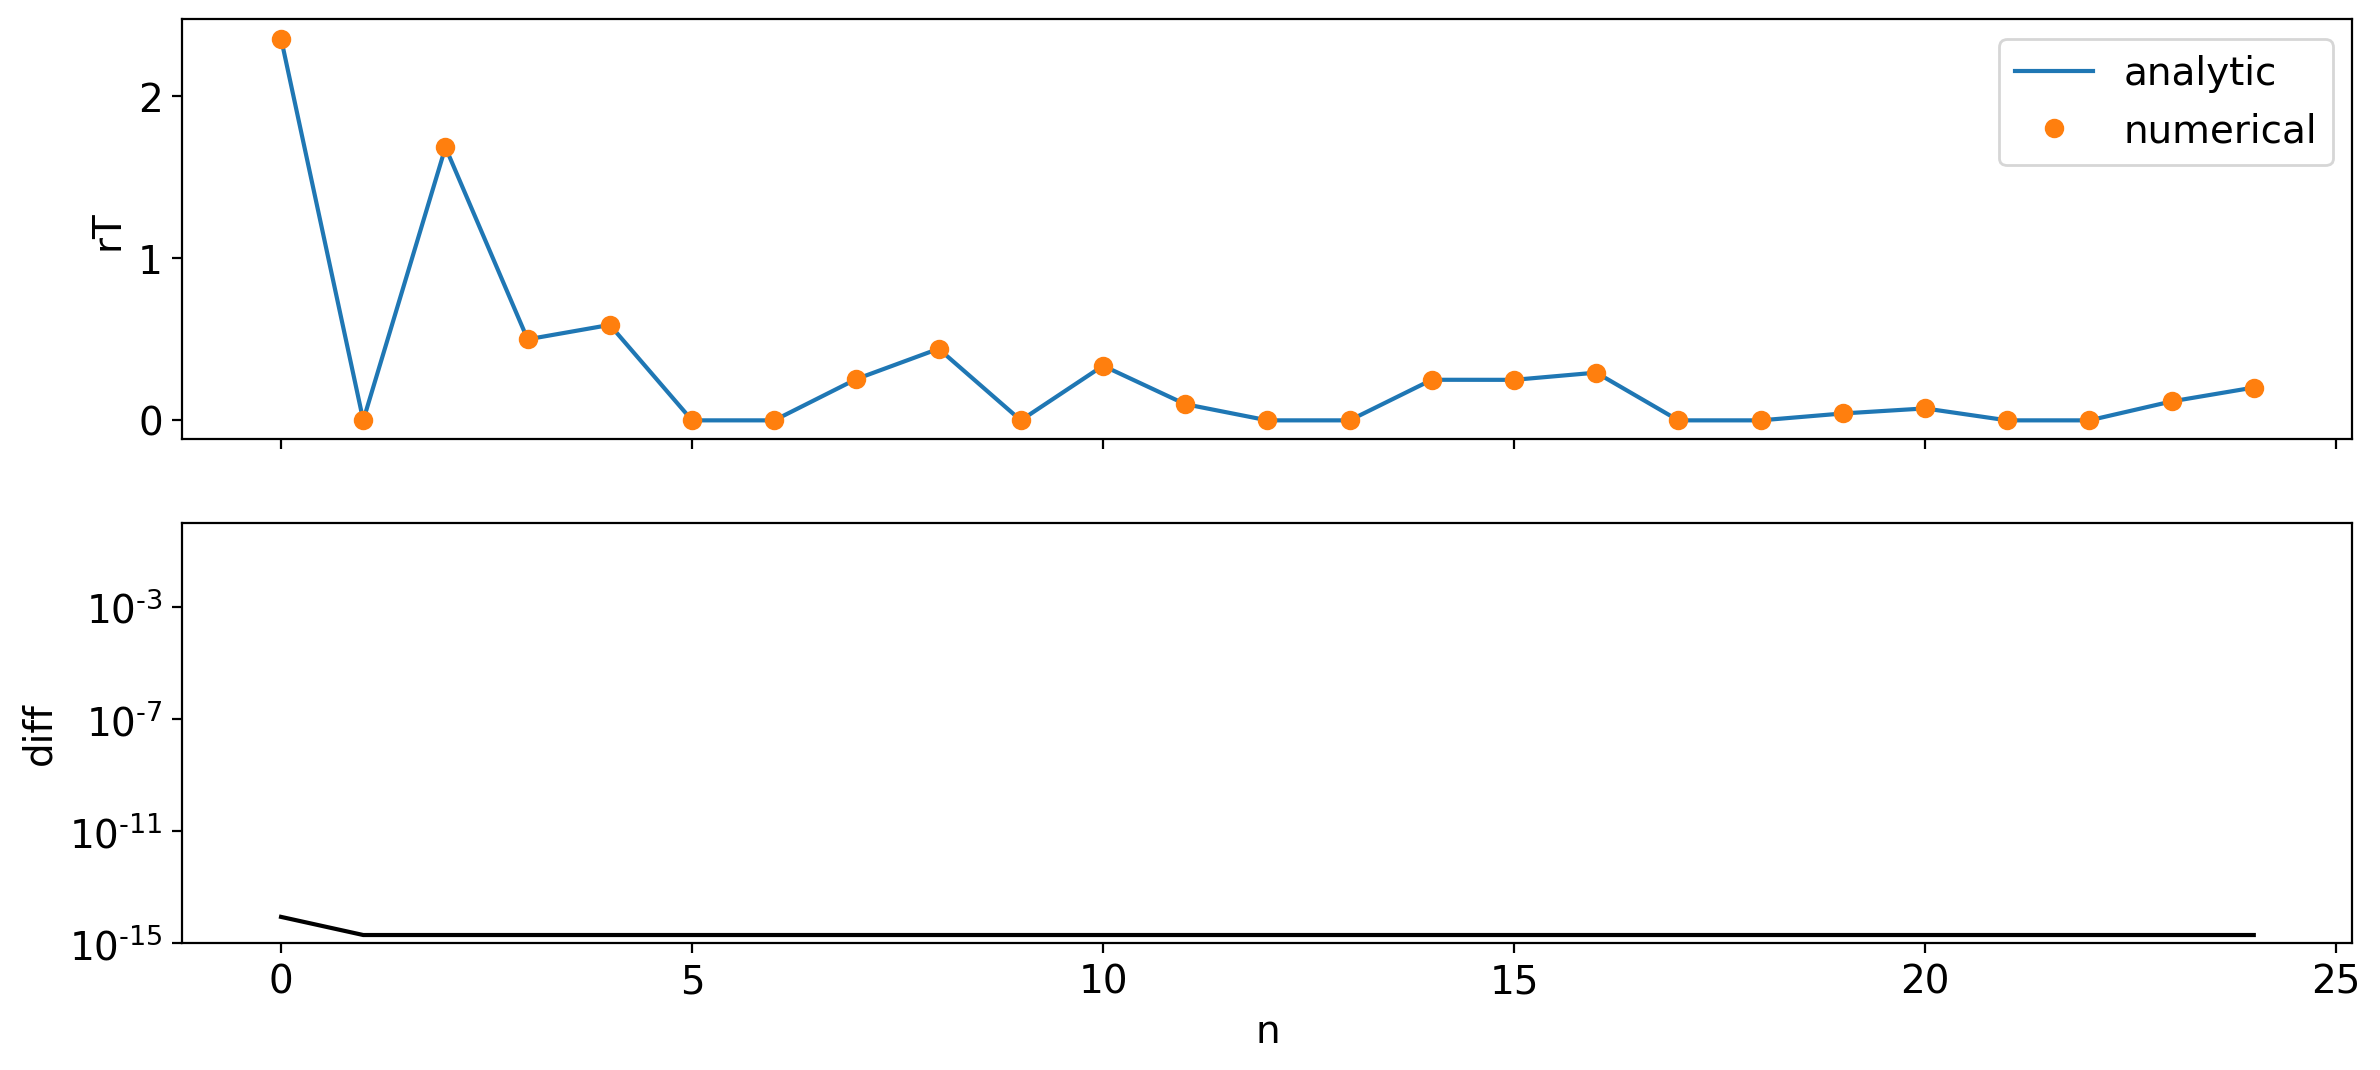

In [110]:
compare(-0.5, 4)

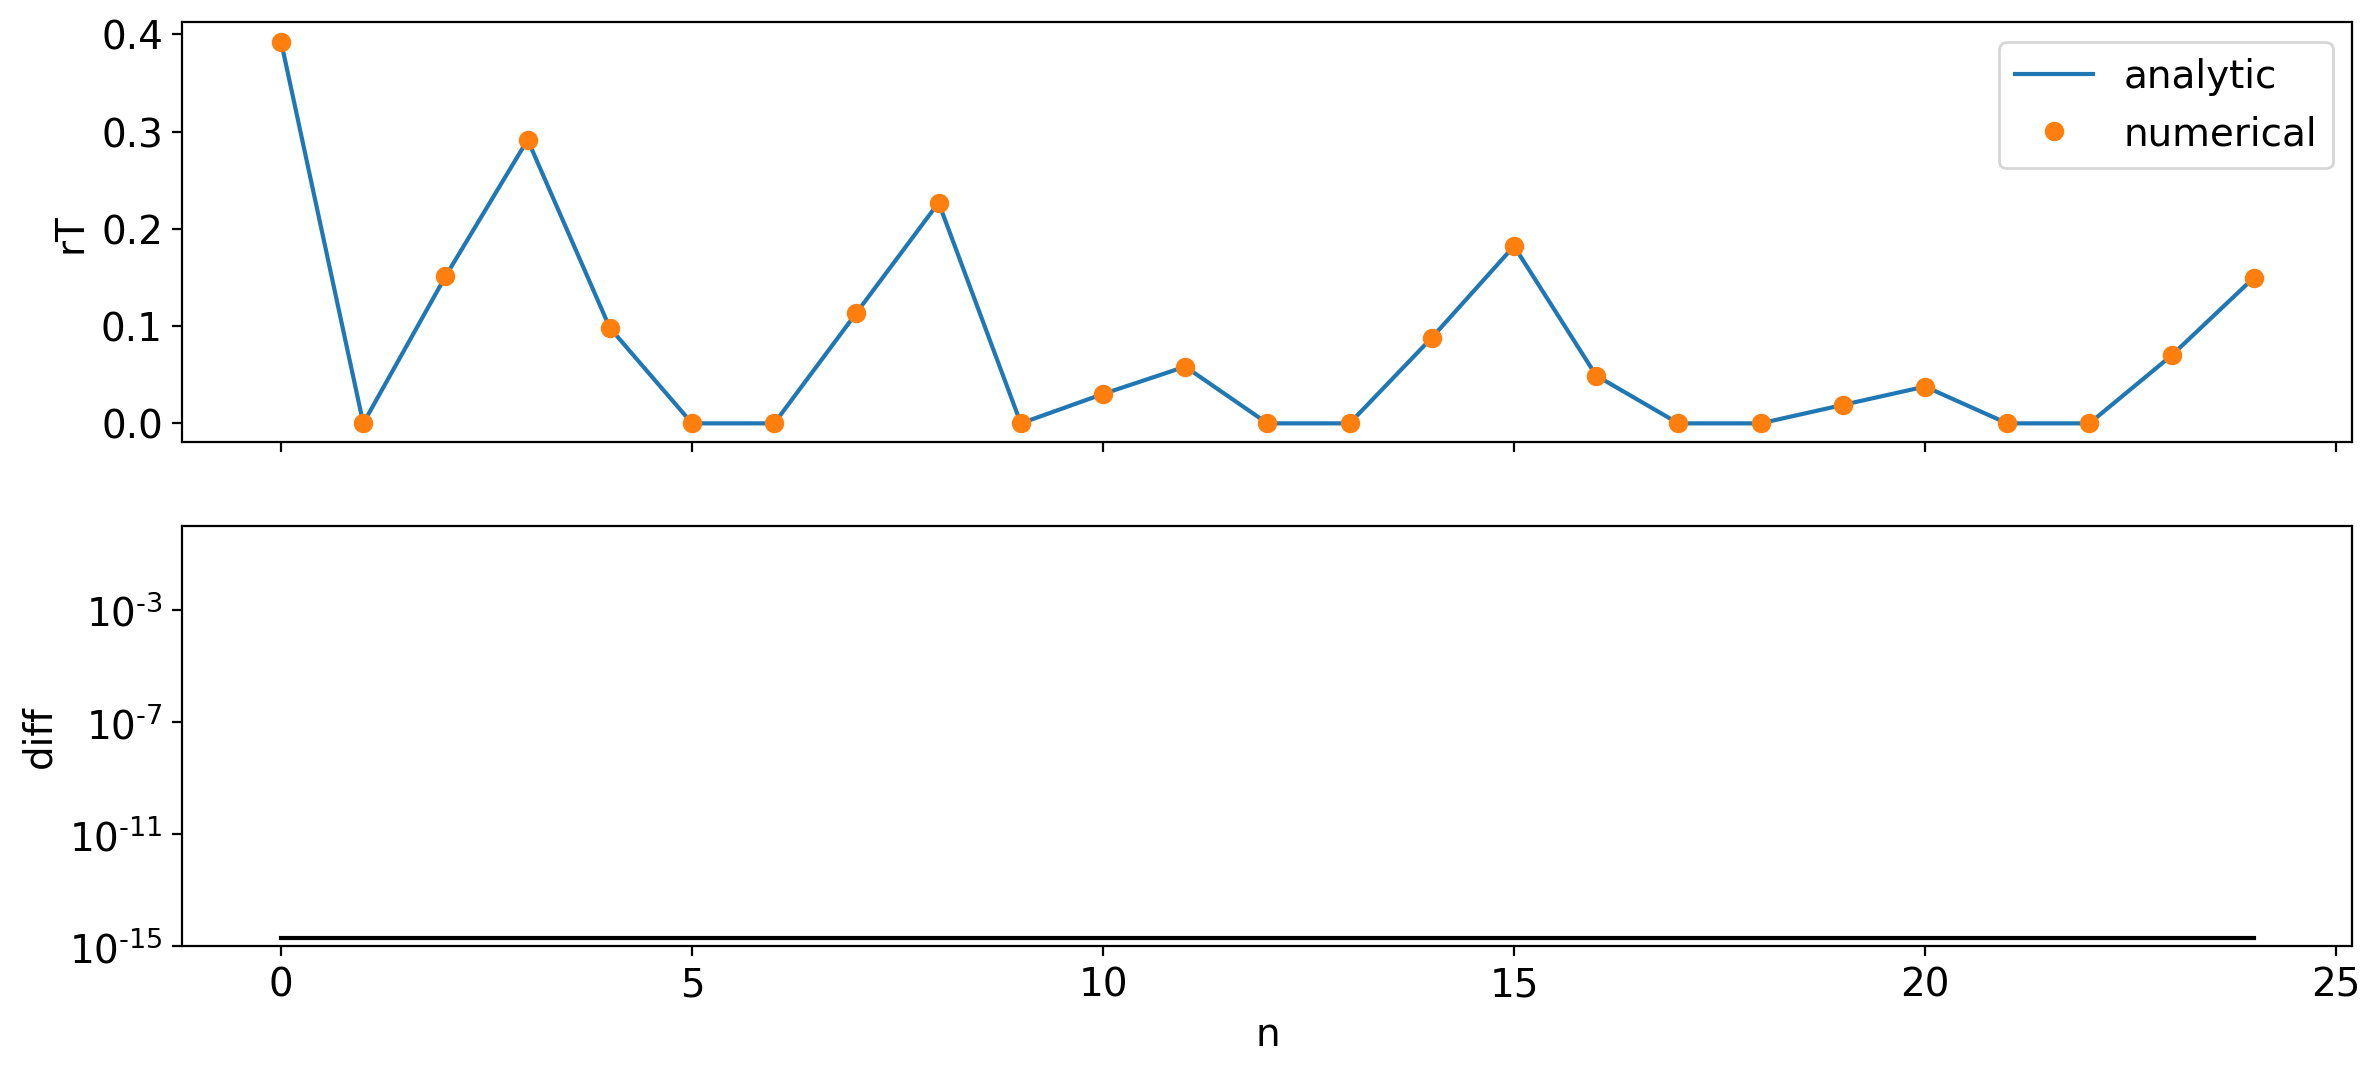

In [111]:
compare(0.75, 4)

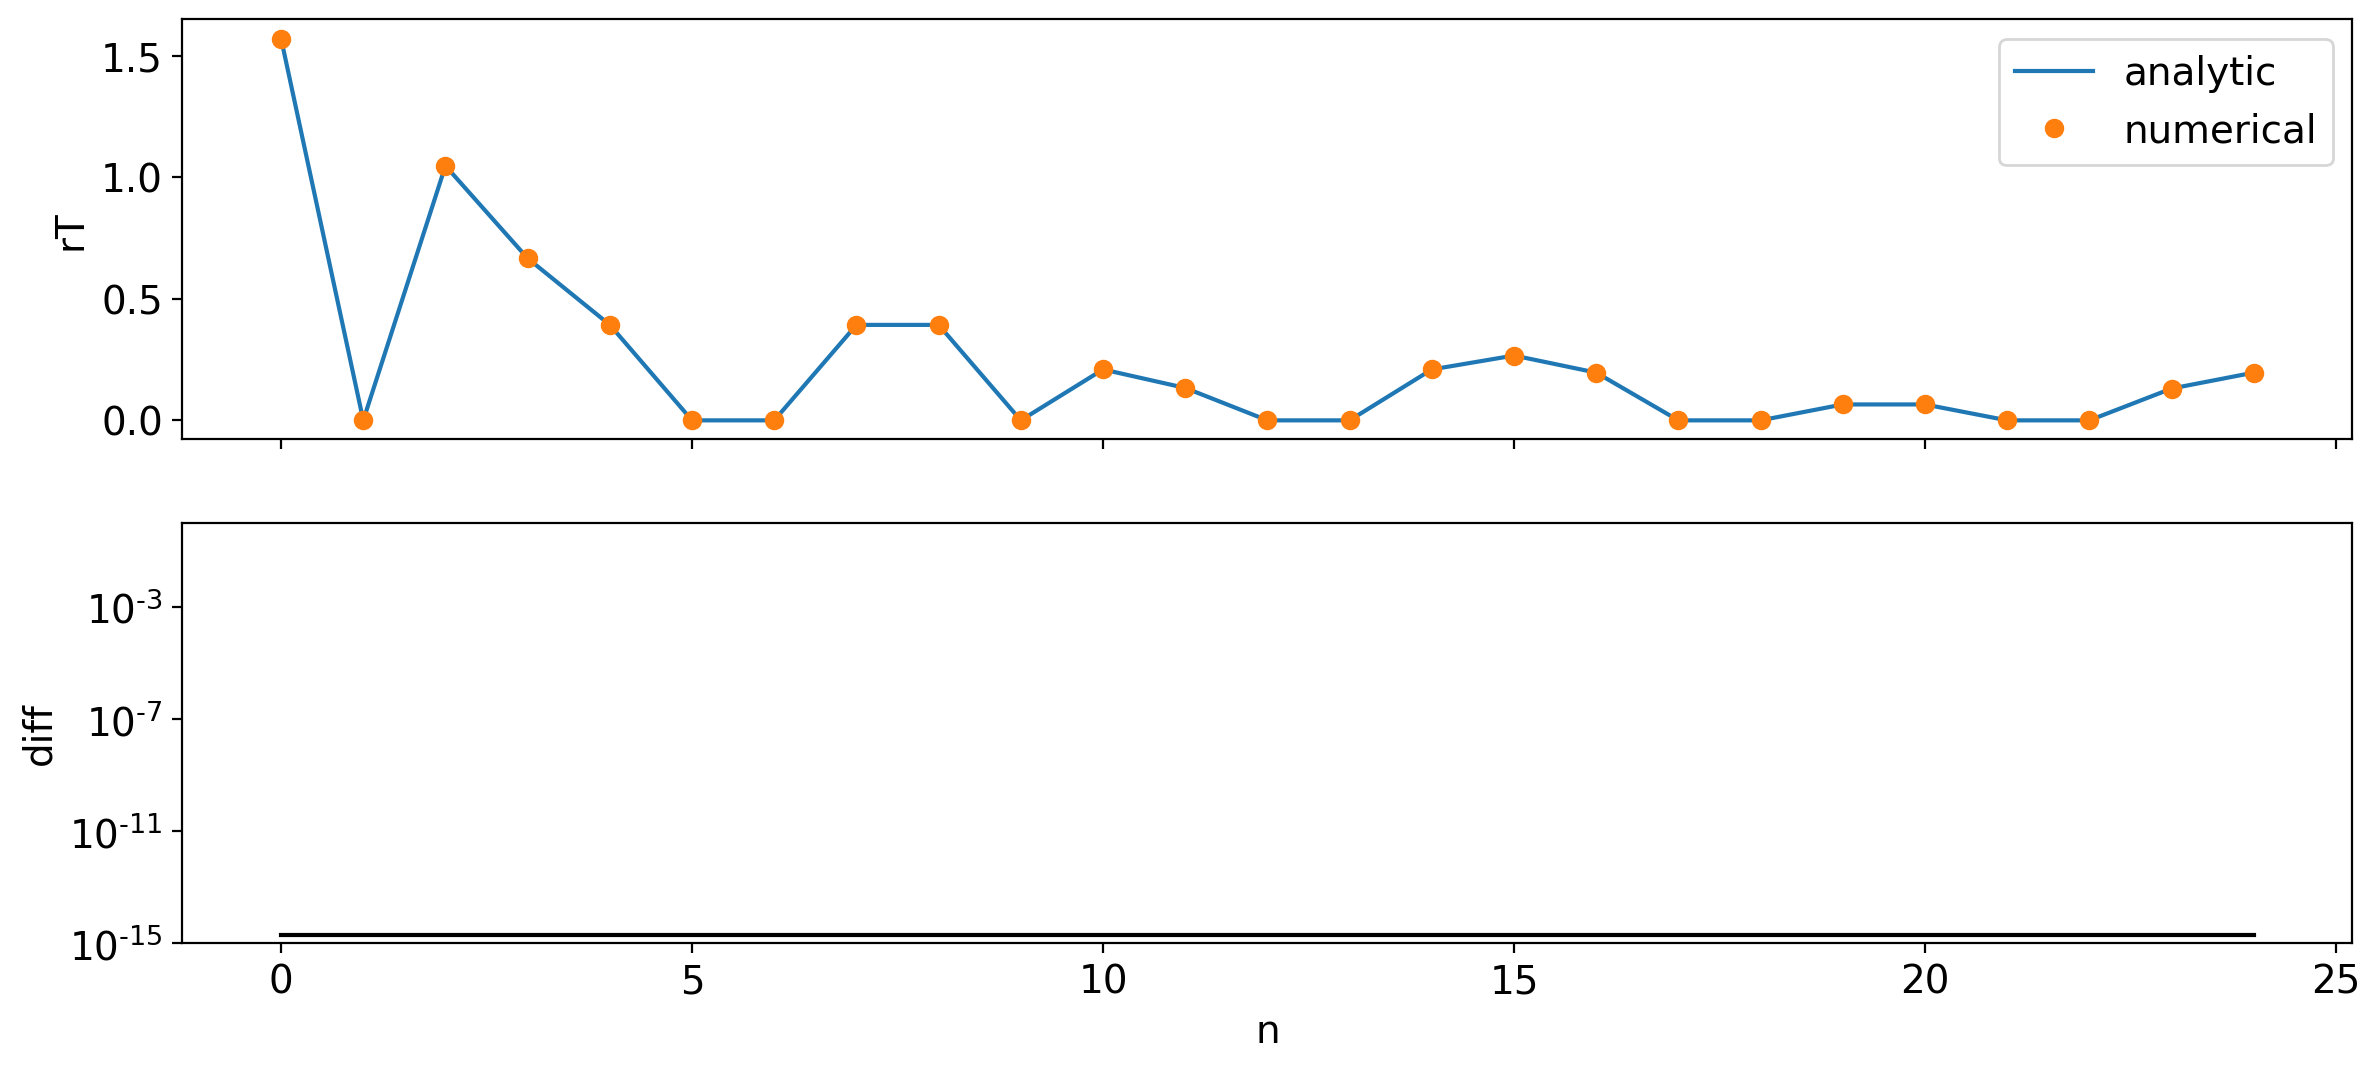

In [112]:
compare(0, 4)

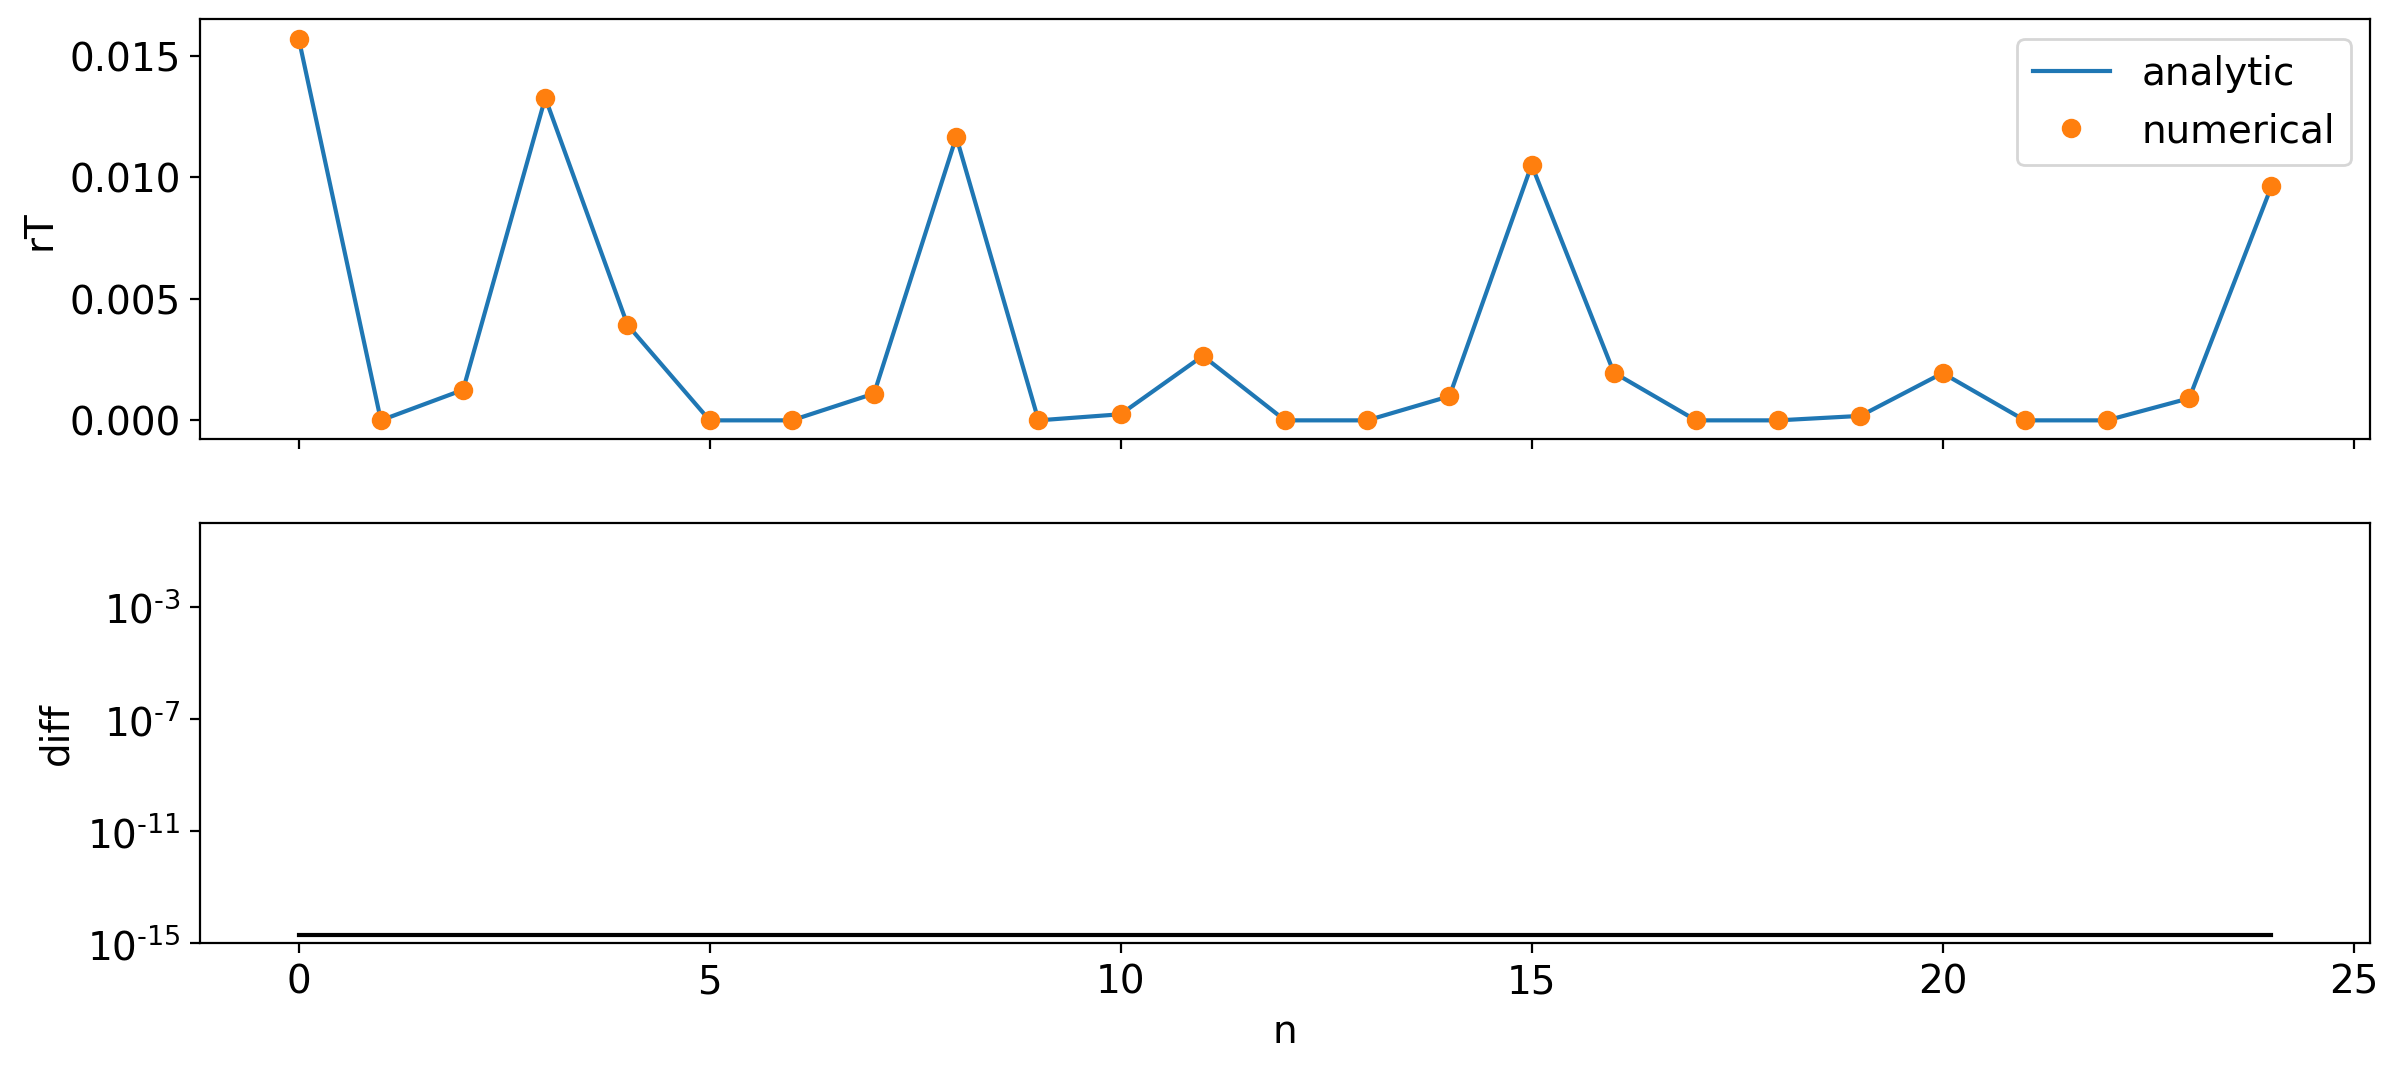

In [113]:
compare(0.99, 4)

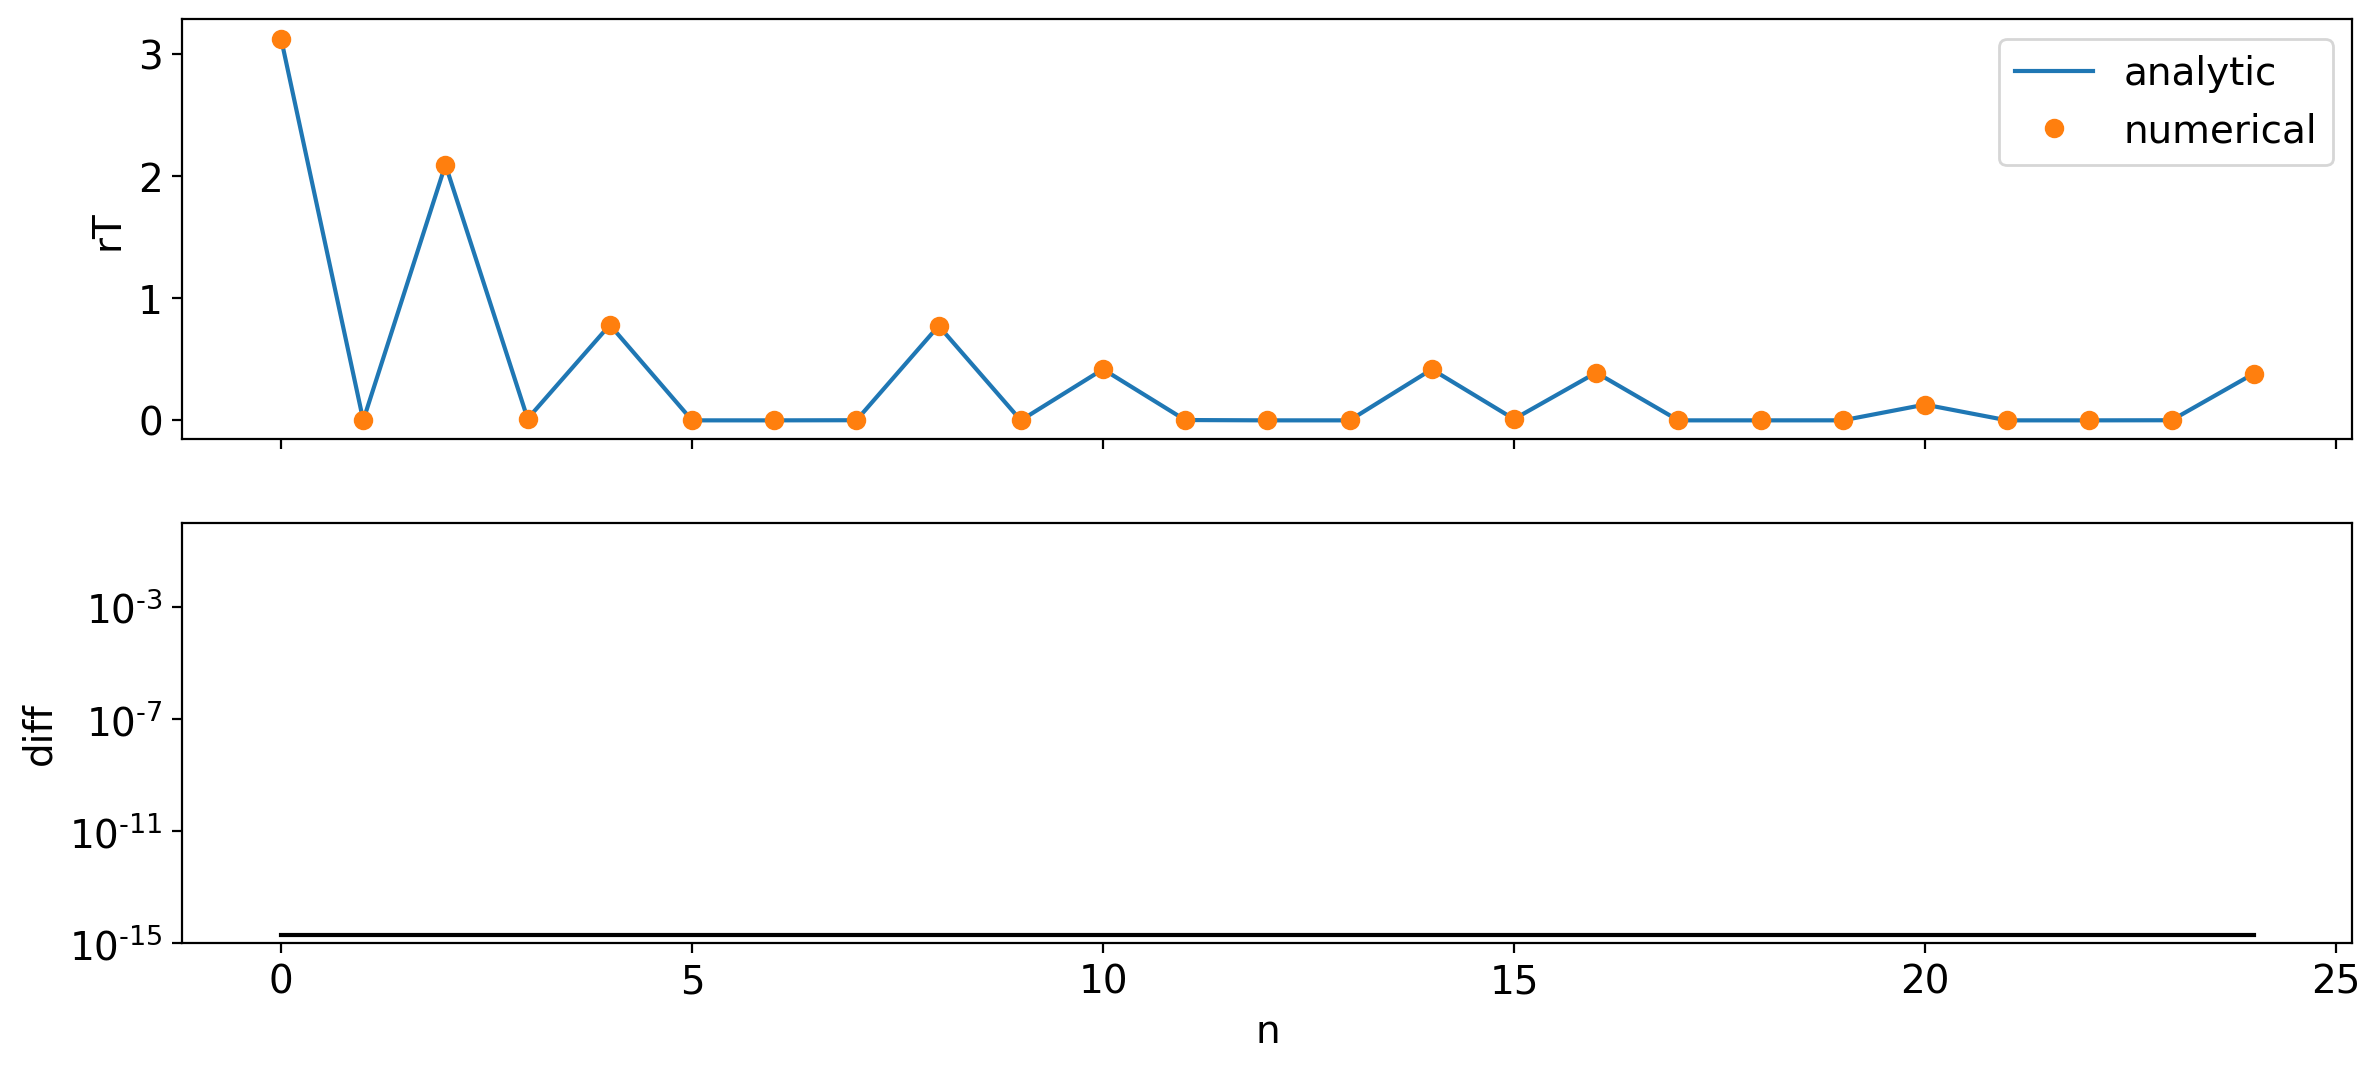

In [114]:
compare(-0.99, 4)